### Install libraries

In [110]:
!pip install kneed

In [162]:
import math

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from kneed import KneeLocator
from sklearn.cluster import KMeans

### Read and process dataset

In [163]:
df = pd.read_csv('InternationalDeclarations.csv', sep=',')

In [164]:
df.columns

Index(['id', 'org:resource', 'concept:name', 'time:timestamp', 'org:role',
       'case:Permit travel permit number', 'case:DeclarationNumber',
       'case:Amount', 'case:RequestedAmount', 'case:Permit TaskNumber',
       'case:Permit BudgetNumber', 'case:OriginalAmount',
       'case:Permit ProjectNumber', 'case:concept:name',
       'case:Permit OrganizationalEntity', 'case:travel permit number',
       'case:Permit RequestedBudget', 'case:id', 'case:Permit ID',
       'case:Permit id', 'case:BudgetNumber', 'case:Permit ActivityNumber',
       'case:AdjustedAmount'],
      dtype='object')

In [165]:
df = df[['case:id', 'concept:name', 'time:timestamp', 'org:resource', 'org:role', 'case:Amount']]

In [166]:
df.head(10)

,case:id,concept:name,time:timestamp,org:resource,org:role,case:Amount
0,declaration 76457,Start trip,2016-10-05 00:00:00+02:00,STAFF MEMBER,EMPLOYEE,39.664561
1,declaration 76457,End trip,2016-10-05 00:00:00+02:00,STAFF MEMBER,EMPLOYEE,39.664561
2,declaration 76457,Permit SUBMITTED by EMPLOYEE,2017-04-06 13:32:10+02:00,STAFF MEMBER,EMPLOYEE,39.664561
3,declaration 76457,Permit FINAL_APPROVED by SUPERVISOR,2017-04-06 13:32:28+02:00,STAFF MEMBER,SUPERVISOR,39.664561
4,declaration 76457,Declaration SUBMITTED by EMPLOYEE,2017-04-07 13:38:14+02:00,STAFF MEMBER,EMPLOYEE,39.664561
5,declaration 76457,Declaration FINAL_APPROVED by SUPERVISOR,2017-04-07 13:40:17+02:00,STAFF MEMBER,SUPERVISOR,39.664561
6,declaration 76457,Request Payment,2017-04-11 15:03:43+02:00,SYSTEM,UNDEFINED,39.664561
7,declaration 76457,Payment Handled,2017-04-13 17:30:53+02:00,SYSTEM,UNDEFINED,39.664561
8,declaration 76667,Start trip,2016-11-21 00:00:00+01:00,STAFF MEMBER,EMPLOYEE,346.544903
9,declaration 76667,End trip,2016-12-22 00:00:00+01:00,STAFF MEMBER,EMPLOYEE,346.544903


In [167]:
len(df['case:id'].unique())

6449

In [168]:
len(df['concept:name'].unique())

34

### Bag-of-activities

In [169]:
df1 = pd.crosstab(index=df['case:id'], columns = df['concept:name'])

In [170]:
df1.head()

concept:name,Declaration APPROVED by ADMINISTRATION,Declaration APPROVED by BUDGET OWNER,Declaration APPROVED by PRE_APPROVER,Declaration APPROVED by SUPERVISOR,Declaration FINAL_APPROVED by DIRECTOR,Declaration FINAL_APPROVED by SUPERVISOR,Declaration REJECTED by ADMINISTRATION,Declaration REJECTED by BUDGET OWNER,Declaration REJECTED by DIRECTOR,Declaration REJECTED by EMPLOYEE,...,Permit REJECTED by BUDGET OWNER,Permit REJECTED by DIRECTOR,Permit REJECTED by EMPLOYEE,Permit REJECTED by MISSING,Permit REJECTED by PRE_APPROVER,Permit REJECTED by SUPERVISOR,Permit SUBMITTED by EMPLOYEE,Request Payment,Send Reminder,Start trip
case:id,,,,,,,,,,,,,,,,,,,,,
declaration 1002,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
declaration 10024,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
declaration 10026,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
declaration 10046,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
declaration 10069,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1


In [171]:
df1.index

Index(['declaration 1002', 'declaration 10024', 'declaration 10026',
       'declaration 10046', 'declaration 10069', 'declaration 10079',
       'declaration 10089', 'declaration 10106', 'declaration 10128',
       'declaration 10138',
       ...
       'declaration 9868', 'declaration 9884', 'declaration 9894',
       'declaration 9906', 'declaration 9918', 'declaration 9934',
       'declaration 9945', 'declaration 9955', 'declaration 9968',
       'declaration 9995'],
      dtype='object', name='case:id', length=6449)

### TF-IDF algorithm

In [172]:
def computeTF(wordDict, bow):
    tfDict = {}
    bowCount = len(bow)
    for word, count in wordDict,items():
        tfDict[word] = count/float(bowCount)
    return tfDict

def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    
    idfDict = dict.fromkeys(docList[0].keys(), 0)
    for doc in docList:
        for word, val in doc.item():
            if val > 0:
                idfDict[word] += 1
                
    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

def computeTFIDF(tfBow, idfs):
    tfidf = {}
    for word, val in tfBow.items():
        tfidf[word] = val*idfs[word]
    return tfidf

### AF-ILF

In [173]:
process_dict = {}
vocabulary = []

for index, row in df.iterrows():
    process = row['case:id']
    activity = row['concept:name'].replace(' ', '_').lower()
    
    if activity not in vocabulary:
        vocabulary.append(activity)
    
    if process not in process_dict:
        process_dict[process] = []
    else:
        process_dict[process].append(activity)
    
print(len(process_dict))

6449


In [174]:
process_dict

{'declaration 76457': ['end_trip',
  'permit_submitted_by_employee',
  'permit_final_approved_by_supervisor',
  'declaration_submitted_by_employee',
  'declaration_final_approved_by_supervisor',
  'request_payment',
  'payment_handled'],
 'declaration 76667': ['end_trip',
  'permit_submitted_by_employee',
  'permit_final_approved_by_supervisor',
  'declaration_submitted_by_employee',
  'declaration_final_approved_by_supervisor',
  'request_payment',
  'payment_handled'],
 'declaration 73654': ['end_trip',
  'permit_submitted_by_employee',
  'permit_final_approved_by_supervisor',
  'declaration_submitted_by_employee',
  'declaration_final_approved_by_supervisor',
  'request_payment',
  'payment_handled'],
 'declaration 73596': ['permit_submitted_by_employee',
  'permit_approved_by_supervisor',
  'permit_final_approved_by_director',
  'declaration_submitted_by_employee',
  'declaration_approved_by_pre_approver',
  'declaration_final_approved_by_supervisor',
  'request_payment',
  'paymen

In [175]:
corpus = []
for process, activity_list in process_dict.items():
    sentense = ' '.join(activity_list)
    corpus.append(sentense)

len(corpus)

6449

In [176]:
corpus

['end_trip permit_submitted_by_employee permit_final_approved_by_supervisor declaration_submitted_by_employee declaration_final_approved_by_supervisor request_payment payment_handled',
 'end_trip permit_submitted_by_employee permit_final_approved_by_supervisor declaration_submitted_by_employee declaration_final_approved_by_supervisor request_payment payment_handled',
 'end_trip permit_submitted_by_employee permit_final_approved_by_supervisor declaration_submitted_by_employee declaration_final_approved_by_supervisor request_payment payment_handled',
 'permit_submitted_by_employee permit_approved_by_supervisor permit_final_approved_by_director declaration_submitted_by_employee declaration_approved_by_pre_approver declaration_final_approved_by_supervisor request_payment payment_handled end_trip',
 'permit_submitted_by_employee permit_approved_by_supervisor permit_final_approved_by_director declaration_submitted_by_employee declaration_approved_by_pre_approver declaration_final_approved_by

In [177]:
vocabulary

['start_trip',
 'end_trip',
 'permit_submitted_by_employee',
 'permit_final_approved_by_supervisor',
 'declaration_submitted_by_employee',
 'declaration_final_approved_by_supervisor',
 'request_payment',
 'payment_handled',
 'permit_approved_by_supervisor',
 'permit_final_approved_by_director',
 'declaration_approved_by_pre_approver',
 'declaration_approved_by_administration',
 'permit_approved_by_pre_approver',
 'declaration_rejected_by_pre_approver',
 'declaration_rejected_by_employee',
 'declaration_saved_by_employee',
 'declaration_rejected_by_missing',
 'permit_rejected_by_missing',
 'declaration_rejected_by_supervisor',
 'declaration_approved_by_supervisor',
 'declaration_final_approved_by_director',
 'permit_rejected_by_pre_approver',
 'permit_rejected_by_employee',
 'declaration_rejected_by_director',
 'permit_rejected_by_supervisor',
 'permit_approved_by_administration',
 'send_reminder',
 'declaration_approved_by_budget_owner',
 'declaration_rejected_by_administration',
 'per

In [178]:
pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)), ('tfid', TfidfTransformer())]).fit(corpus)

In [179]:
pipe['count'].transform(corpus).toarray()

array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [180]:
pipe['tfid'].idf_

array([1.12186111, 1.        , 2.99989985, 1.18362473, 1.06683573,
       1.07867414, 1.04211482, 1.0414682 , 3.31349713, 3.31349713,
       3.44568594, 1.2707716 , 3.51034373, 5.3529948 , 2.46933899,
       5.5523277 , 5.17671556, 6.01063529, 4.95965105, 4.26244707,
       4.2705772 , 6.55295958, 4.40119738, 8.1623975 , 5.23923592,
       1.30846503, 3.76302222, 2.26634314, 2.6109895 , 2.30789881,
       5.37738626, 6.05826334, 6.37063803, 9.07868823])

In [181]:
X_afilf = pipe.transform(corpus)

In [192]:
mat = scipy.sparse.eye(2)
dfx = pd.DataFrame.sparse.from_spmatrix(X_afilf)
dfx.columns = vocabulary
dfx

,start_trip,end_trip,permit_submitted_by_employee,permit_final_approved_by_supervisor,declaration_submitted_by_employee,declaration_final_approved_by_supervisor,request_payment,payment_handled,permit_approved_by_supervisor,permit_final_approved_by_director,...,permit_rejected_by_supervisor,permit_approved_by_administration,send_reminder,declaration_approved_by_budget_owner,declaration_rejected_by_administration,permit_approved_by_budget_owner,permit_rejected_by_administration,declaration_rejected_by_budget_owner,permit_rejected_by_budget_owner,permit_rejected_by_director
0,0.000000,0.251000,0.752976,0.297090,0.267776,0.270748,0.261571,0.261409,0.00000,0.00000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.000000,0.251000,0.752976,0.297090,0.267776,0.270748,0.261571,0.261409,0.00000,0.00000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,0.000000,0.251000,0.752976,0.297090,0.267776,0.270748,0.261571,0.261409,0.00000,0.00000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.000000,0.143884,0.431638,0.000000,0.153501,0.155204,0.149944,0.149851,0.47676,0.47676,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.000000,0.143884,0.431638,0.000000,0.153501,0.155204,0.149944,0.149851,0.47676,0.47676,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6444,0.239609,0.213582,0.000000,0.252801,0.227857,0.230385,0.222577,0.222439,0.00000,0.00000,...,0.0,0.279465,0.0,0.484050,0.000000,0.492926,0.000000,0.0,0.0,0.0
6445,0.000000,0.097614,0.585667,0.115539,0.104139,0.105294,0.101725,0.101662,0.00000,0.00000,...,0.0,0.127725,0.0,0.221228,0.000000,0.225284,0.524911,0.0,0.0,0.0
6446,0.239609,0.213582,0.000000,0.252801,0.227857,0.230385,0.222577,0.222439,0.00000,0.00000,...,0.0,0.279465,0.0,0.484050,0.000000,0.492926,0.000000,0.0,0.0,0.0
6447,0.254544,0.226894,0.000000,0.268558,0.242059,0.000000,0.000000,0.000000,0.00000,0.00000,...,0.0,0.296883,0.0,0.000000,0.592418,0.000000,0.000000,0.0,0.0,0.0


### Clusterization

In [182]:
# X = df1.to_numpy()
X = X_afilf

In [183]:
inertia = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    inertia.append(kmeanModel.inertia_)

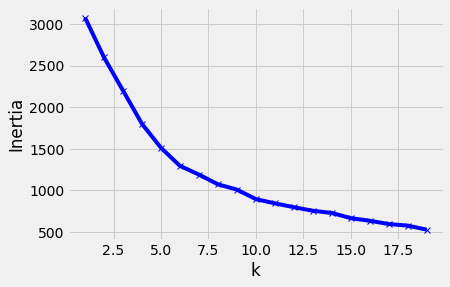

In [184]:
# Plot the elbow
plt.style.use("fivethirtyeight")
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

In [185]:
cluster_df = pd.DataFrame({'Cluster':range(1,20), 'sse':inertia})
cluster_df.head()

,Cluster,sse
0,1,3078.924635
1,2,2600.227293
2,3,2201.769974
3,4,1801.500420
4,5,1513.286635


In [186]:
kl = KneeLocator(range(1, 20), inertia, curve="convex", direction="decreasing" )

In [187]:
cluster_number = kl.elbow
cluster_number

6

### Train K-Means

In [188]:
km = KMeans(n_clusters=cluster_number)
km.fit(X)

preds = km.predict(X)

In [161]:
preds

array([4, 4, 4, ..., 2, 1, 1], dtype=int32)

### Draw clusters

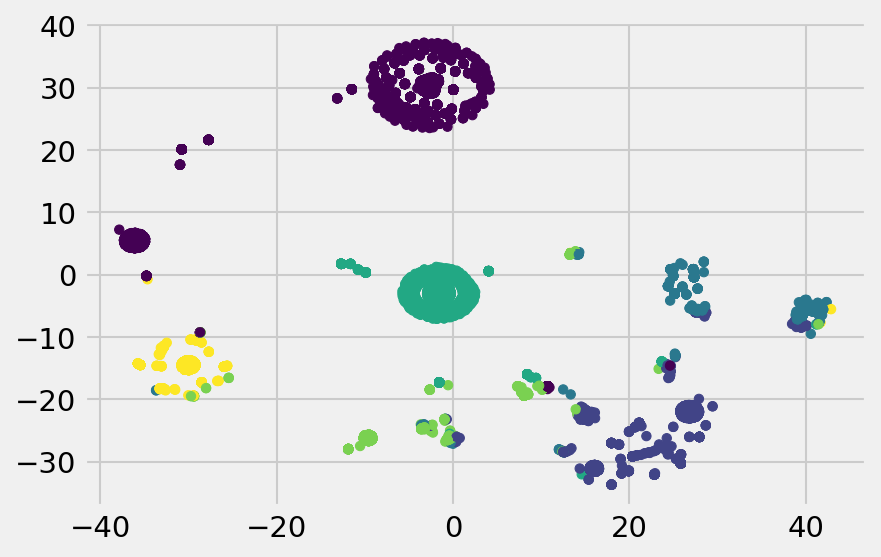

In [195]:
tsne = TSNE(perplexity=150, n_iter=10000)
Y = tsne.fit_transform(X)
plt.figure(dpi = 150)
plt.scatter(Y[:, 0], Y[:, 1], 20, preds)
plt.show()

### Count used activities in clusters

In [289]:
def get_activities_by_cluster(dfx, km, cluster_number):
    result = km.predict(dfx)
    result_df = dfx[:]
    result_df['pred'] = result
    for i in range(0, cluster_number):
        print("Cluster #", i)
        result_df_0 = result_df[result_df['pred'] == i]
        result_df_0 = (result_df_0 != 0).any(axis=0)
        print(len(result_df_0[result_df_0 == True]))
        print()
    

In [290]:
get_activities_by_cluster(dfx, km, 6)

Cluster # 0
13

Cluster # 1
30

Cluster # 2
34

Cluster # 3
21

Cluster # 4
34

Cluster # 5
27



/Users/a18234587/jupyter/ENV/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
